In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [20]:

# Load the CSV without setting index yet
data = pd.read_csv(r'..\RawMeasurementData\Atmosphere\RefStation_detailed_data_localtime_March-August2024.csv')

In [21]:

# 🔹 Ensure "Date" and "Time" columns exist
if 'Date' in data.columns and 'Time' in data.columns:
    # Combine Date and Time into a single Datetime column
    data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    # Set Datetime as the index
    data.set_index('Datetime', inplace=True)
    # Drop the original Date and Time columns
    data.drop(columns=['Date', 'Time'], inplace=True)
else:
    print(" 'Date' and 'Time' columns not found in the dataset!")


In [22]:

# 🔹 Ensure all columns are numeric
numeric_columns = {
    "TM°C": "Avg Temperature (C)",
    "TX°C": "Max Temperature (C)",
    "TN°C": "Min Temperature(C)",
    "HRM%": "Relative Humidity",
    "PPTmm": "Precipitation (mm)",
    "VVM (10 m)km/h": "Avg Windspeed (km/h)",
    "DVM (10 m)graus": "Avg Wind Direction",
    "VVX (10 m)km/h": "Max Windspeed (km/h)",
    "PMhPa": "Air Pressure (hPa)",
    "RSW/m2": "Avg Solar Irradiance (W/m2)"
}

# Rename the columns
data.rename(columns=numeric_columns, inplace=True)

# Convert to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Fix duplicate timestamps if any
data = data[~data.index.duplicated(keep='first')]

# Sort the index to avoid jumps
data = data.sort_index()

# Interpolate missing values
data.interpolate(method='linear', inplace=True)




In [23]:
# set a date. 
# then export all data ready for CFD inputs. 
# Windspeed and Direction split into x and y components in 10min intervals
# Air Temperature in 10mins
# Solar Irradiation recomputed into direct and diffuse radiation hourly. 
# Winddirection in hourly intervals 

In [24]:
from datetime import date

# ✅ Chosen non-rainy dates for simulation input
selected_dates = [
    date(2024, 3, 17),
    date(2024, 3, 24),
    date(2024, 4, 1),
    date(2024, 4, 12),
    date(2024, 4, 23),
    date(2024, 5, 24),
    date(2024, 5, 29),
    date(2024, 6, 8),
    date(2024, 6, 10),
    date(2024, 6, 21),
    date(2024, 7, 20),
    date(2024, 7, 31),
]

latitude = 41.3891
longitude = 2.1121

# Export Profiles

In [25]:
import numpy as np
import pandas as pd
from datetime import date

# -- Input: your selected non-rainy dates --
selected_dates = [
    date(2024, 3, 17), date(2024, 3, 24), date(2024, 4, 1), date(2024, 4, 12),
    date(2024, 4, 23), date(2024, 5, 24), date(2024, 5, 29), date(2024, 6, 8),
    date(2024, 6, 10), date(2024, 6, 21), date(2024, 7, 20), date(2024, 7, 31),
]

# -- Storage for each day's extracted data --
results_by_day = {}

for day in selected_dates:
    #  Filter for the given day
    df_day = data.loc[data.index.date == day].copy()

    # Keep only full-hour rows (00:00, 01:00, ..., 23:00)
    df_hourly = df_day[df_day.index.minute == 0].copy()

    if df_hourly.empty or len(df_hourly) < 24:
        print(f"⚠️ Skipping {day} — not enough hourly records.")
        continue

    #  Convert windspeed and temperature
    df_hourly['U (m/s)'] = df_hourly['Avg Windspeed (km/h)'] / 3.6
    df_hourly['Avg Temperature (K)'] = df_hourly['Avg Temperature (C)'] + 273.15

    #  Calculate Ux, Uy
    theta_rad = np.radians((df_hourly['Avg Wind Direction'] + 180) % 360)
    df_hourly['Ux (m/s)'] = df_hourly['U (m/s)'] * np.sin(theta_rad)
    df_hourly['Uy (m/s)'] = df_hourly['U (m/s)'] * np.cos(theta_rad)

    #  Extract hourly profiles
    wind_components = df_hourly[['Ux (m/s)', 'Uy (m/s)']]
    windspeed_hourly = df_hourly[['U (m/s)']]
    temp_hourly = df_hourly[['Avg Temperature (K)']]
    winddir_hourly = df_hourly[['Avg Wind Direction']].rename(columns={'Avg Wind Direction': 'Wind Direction (deg)'})
    solar_hourly = df_hourly[['Avg Solar Irradiance (W/m2)']]

    #  Store in dictionary
    results_by_day[day] = {
        'df_hourly': df_hourly,  # 👈 add this line
        'wind_components': wind_components,
        'windspeed': windspeed_hourly,
        'temperature': temp_hourly,
        'wind_direction': winddir_hourly,
        'solar': solar_hourly,
    }

    # Optional preview for each date
    print(f"\n Extracted data for {day}")
    print(wind_components.head())

# Now `results_by_day[date]` gives you each of the 5 profiles for any processed day.



 Extracted data for 2024-03-17
                     Ux (m/s)      Uy (m/s)
Datetime                                   
2024-03-17 00:00:00  0.884019  9.291419e-02
2024-03-17 01:00:00  0.357974  1.519510e-01
2024-03-17 02:00:00  2.016484 -1.117756e+00
2024-03-17 03:00:00  1.194263  2.084593e-02
2024-03-17 04:00:00  1.305556  7.994222e-17

 Extracted data for 2024-03-24
                     Ux (m/s)  Uy (m/s)
Datetime                               
2024-03-24 00:00:00 -0.121869  0.992546
2024-03-24 01:00:00 -1.189899 -0.104103
2024-03-24 02:00:00 -0.560758 -1.054632
2024-03-24 03:00:00 -0.446526 -1.226821
2024-03-24 04:00:00 -1.388043  0.048472

 Extracted data for 2024-04-01
                     Ux (m/s)  Uy (m/s)
Datetime                               
2024-04-01 00:00:00  1.983796 -0.722043
2024-04-01 01:00:00  1.388008 -0.971893
2024-04-01 02:00:00  2.064978 -0.438925
2024-04-01 03:00:00  1.738731 -0.738048
2024-04-01 04:00:00  1.335672 -0.900922

 Extracted data for 2024-04-12
    

In [26]:
# Low windspeeds in start of the day cause instability in sim.

# Constraints:
#t=0 to t=2:
#Windspeed set to 1.2 m/s
#Wind direction set to original t=1 direction (to avoid sudden angle swings)

#t=3:
#Wind direction change from t=2 capped at ±45°

#t=3 onwards:
#No constraints applied (natural profile retained)

for day in selected_dates:
    df_day = data.loc[data.index.date == day].copy()
    df_hourly = df_day[df_day.index.minute == 0].copy()

    if df_hourly.empty or len(df_hourly) < 24:
        print(f"⚠️ Skipping {day} — not enough hourly records.")
        continue

    # Convert units
    df_hourly['U (m/s)'] = df_hourly['Avg Windspeed (km/h)'] / 3.6
    df_hourly['Avg Temperature (K)'] = df_hourly['Avg Temperature (C)'] + 273.15

    # ➤ Enforce stable windspeed and direction for t=0 to t=2
    df_hourly.loc[df_hourly.index[:3], 'U (m/s)'] = 1.2
    stable_dir = df_hourly.iloc[1]['Avg Wind Direction']
    df_hourly.loc[df_hourly.index[:3], 'Avg Wind Direction'] = stable_dir

    # ➤ Smooth wind direction at t=3 if >±45° from t=2
    wd = df_hourly['Avg Wind Direction'].values.copy()
    delta = (wd[3] - wd[2] + 180) % 360 - 180
    if abs(delta) > 45:
        wd[3] = wd[2] + np.clip(delta, -45, 45)
        wd[3] %= 360
    df_hourly['Avg Wind Direction'] = wd

    # ➤ Recalculate Ux, Uy
    theta_rad = np.radians((df_hourly['Avg Wind Direction'] + 180) % 360)
    df_hourly['Ux (m/s)'] = df_hourly['U (m/s)'] * np.sin(theta_rad)
    df_hourly['Uy (m/s)'] = df_hourly['U (m/s)'] * np.cos(theta_rad)

    # ➤ Store results
    results_by_day[day] = {
        'df_hourly': df_hourly,
        'wind_components': df_hourly[['Ux (m/s)', 'Uy (m/s)']],
        'windspeed': df_hourly[['U (m/s)']],
        'temperature': df_hourly[['Avg Temperature (K)']],
        'wind_direction': df_hourly[['Avg Wind Direction']].rename(columns={'Avg Wind Direction': 'Wind Direction (deg)'}),
        'solar': df_hourly[['Avg Solar Irradiance (W/m2)']],
    }

    print(f"\n✅ Final input profile created for {day}")


✅ Final input profile created for 2024-03-17

✅ Final input profile created for 2024-03-24

✅ Final input profile created for 2024-04-01

✅ Final input profile created for 2024-04-12

✅ Final input profile created for 2024-04-23

✅ Final input profile created for 2024-05-24

✅ Final input profile created for 2024-05-29

✅ Final input profile created for 2024-06-08

✅ Final input profile created for 2024-06-10

✅ Final input profile created for 2024-06-21

✅ Final input profile created for 2024-07-20

✅ Final input profile created for 2024-07-31


In [ ]:
import os
import pandas as pd

# Ensure output directory exists one level above `src`
output_dir = os.path.join("..", "SimulationInputs/PreprocessedSimulationInputs")
os.makedirs(output_dir, exist_ok=True)

# Export all variables + special-format files
for day, profiles in results_by_day.items():
    date_str = day.strftime("%Y-%m-%d")

    # 🔹 Save regular CSVs
    profiles['wind_components'].to_csv(os.path.join(output_dir, f"{date_str}_wind_components_hourly.csv"))
    # profiles['temperature'].to_csv(os.path.join(output_dir, f"{date_str}_temperature_hourly.csv"))
    profiles['wind_direction'].to_csv(os.path.join(output_dir, f"{date_str}_wind_direction_hourly.csv"))
    # profiles['windspeed'].to_csv(os.path.join(output_dir, f"{date_str}_wind_speed_hourly.csv"))
   
    # ======================
    # 🔸 Relative Humidity
    # ======================
    df_hourly = profiles["df_hourly"]  # 👈 retrieve from the current profile
    rh_df = df_hourly[["Relative Humidity"]].copy()
    rh_df = rh_df.resample("1H").first().reset_index()
    rh_df["time"] = rh_df["Datetime"].dt.hour * 3600
    rh_df = rh_df.rename(columns={"Relative Humidity": "humidity"})
    rh_df = rh_df[["time", "humidity"]]

    # Add 86400s row with same value as 23:00
    last_val = rh_df.iloc[-1]["humidity"]
    rh_df = pd.concat([
        rh_df,
        pd.DataFrame([{"time": 86400, "humidity": last_val}])
    ], ignore_index=True)

    rh_path = os.path.join(output_dir, f"{date_str}_humidity_hourly.csv")
    with open(rh_path, 'w', newline='') as f:
        f.write("[Name]\n")
        f.write("humidity\n")
        f.write("[Data]\n")
        rh_df.to_csv(f, index=False, line_terminator='\n')
 
    # ======================
    # 🔸 Wind Speed
    # ======================
    ws_df = profiles["windspeed"].copy()
    ws_df = ws_df.resample("1H").first().reset_index()
    ws_df["time"] = ws_df["Datetime"].dt.hour * 3600
    ws_df = ws_df.rename(columns={"U (m/s)": "windspeed"})
    ws_df = ws_df[["time", "windspeed"]]

    # Add 86400s row with same value as 23:00
    last_val = ws_df.iloc[-1]["windspeed"]
    ws_df = pd.concat([
        ws_df,
        pd.DataFrame([{"time": 86400, "windspeed": last_val}])
    ], ignore_index=True)

    wind_path = os.path.join(output_dir, f"{date_str}_wind_speed_hourly.csv")
    with open(wind_path, 'w', newline='') as f:
        f.write("[Name]\n")
        f.write("windspeed\n")
        f.write("[Data]\n")
        ws_df.to_csv(f, index=False, line_terminator='\n')

    # ======================
    # 🔸 Wind Components (X & Y)
    # ======================
    wind_df = profiles["wind_components"].copy()
    wind_df = wind_df.resample("1H").first().reset_index()
    wind_df["time"] = wind_df["Datetime"].dt.hour * 3600

    for comp, label in zip(["Ux (m/s)", "Uy (m/s)"], ["x-component", "y-component"]):
        comp_df = wind_df[["time", comp]].rename(columns={comp: "velocity"})

        # Add 86400s row with same value as 23:00
        last_val = comp_df.iloc[-1]["velocity"]
        comp_df = pd.concat([
            comp_df,
            pd.DataFrame([{"time": 86400, "velocity": last_val}])
        ], ignore_index=True)

        comp_path = os.path.join(output_dir, f"{date_str}_{label}_hourly.csv")
        with open(comp_path, 'w', newline='') as f:
            f.write("[Name]\n")
            f.write(f"{label}\n")
            f.write("[Data]\n")
            comp_df.to_csv(f, index=False, line_terminator='\n')

    # ======================
    # 🔸 Solar Irradiance
    # ======================
    solar_df = profiles["solar"].copy()
    solar_df = solar_df.resample("1H").first().reset_index()
    solar_df["time"] = solar_df["Datetime"].dt.hour * 3600
    solar_df = solar_df.rename(columns={"Avg Solar Irradiance (W/m2)": "irradiation"})
    solar_df = solar_df[["time", "irradiation"]]

    # Add 86400s row with same value as 23:00
    last_row = solar_df.iloc[-1]
    solar_df = pd.concat([
        solar_df,
        pd.DataFrame([{"time": 86400, "irradiation": last_row["irradiation"]}])
    ], ignore_index=True)

    solar_path = os.path.join(output_dir, f"{date_str}_solar_irradiance_hourly.csv")
    with open(solar_path, 'w', newline='') as f:
        f.write("[Name]\n")
        f.write("GlobalSolarIrrad\n")
        f.write("[Data]\n")
        solar_df.to_csv(f, index=False, line_terminator='\n')

    # ======================
    # 🔸 Air Temperature
    # ======================
    temp_df = profiles["temperature"].copy()
    temp_df = temp_df.resample("1H").first().reset_index()
    temp_df["time"] = temp_df["Datetime"].dt.hour * 3600
    temp_df = temp_df.rename(columns={"Avg Temperature (K)": "temperature"})
    temp_df = temp_df[["time", "temperature"]]

    # Add 86400s row with same value as 23:00
    last_temp = temp_df.iloc[-1]
    temp_df = pd.concat([
        temp_df,
        pd.DataFrame([{"time": 86400, "temperature": last_temp["temperature"]}])
    ], ignore_index=True)

    temp_path = os.path.join(output_dir, f"{date_str}_temperature_hourly.csv")
    with open(temp_path, 'w', newline='') as f:
        f.write("[Name]\n")
        f.write("airtemp-K\n")
        f.write("[Data]\n")
        temp_df.to_csv(f, index=False, line_terminator='\n')

    print(f"📤 Saved all CSVs for {date_str} (incl. special formats for solar & temp)")


📤 Saved all CSVs for 2024-03-17 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-03-24 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-04-01 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-04-12 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-04-23 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-05-24 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-05-29 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-06-08 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-06-10 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-06-21 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-07-20 (incl. special formats for solar & temp)
📤 Saved all CSVs for 2024-07-31 (incl. special formats for solar & temp)


# Compute Solar load

In [10]:
import os

# Define output folder for the solar irradiation command files
command_output_dir = os.path.join("..", "SimulationInputs", "SolarIrradCommands")
os.makedirs(command_output_dir, exist_ok=True)

# Fixed split
diffuse_fraction = 0.12
direct_fraction = 1 - diffuse_fraction

for day, profiles in results_by_day.items():
    date_str = day.strftime("%Y-%m-%d")

    # Extract and resample solar data hourly
    solar_df = profiles["solar"].copy().resample("1H").first().reset_index()
    solar_df["time"] = solar_df["Datetime"].dt.hour * 3600

    # Add final row at 86400s using value at 23:00
    last_val = solar_df.iloc[-1]["Avg Solar Irradiance (W/m2)"]
    solar_df = pd.concat([
        solar_df,
        pd.DataFrame([{"Datetime": None, "Avg Solar Irradiance (W/m2)": last_val, "time": 86400}])
    ], ignore_index=True)

    # Compute direct and diffuse
    solar_df["direct"] = solar_df["Avg Solar Irradiance (W/m2)"] * direct_fraction
    solar_df["diffuse"] = solar_df["Avg Solar Irradiance (W/m2)"] * diffuse_fraction

    # Format into strings
    direct_pairs = " ".join(f"{int(t)} {round(v, 2)}" for t, v in zip(solar_df["time"], solar_df["direct"]))
    diffuse_pairs = " ".join(f"{int(t)} {round(v, 2)}" for t, v in zip(solar_df["time"], solar_df["diffuse"]))
    n_points = len(solar_df)

    # Compute average operating values
    avg_temp_K = profiles["temperature"]["Avg Temperature (K)"].mean()
    avg_pressure = data[data.index.date == day]['Air Pressure (hPa)'].mean()
    # fallback if separate pressure not available

    # Compose final command string
    command_text = f"""/define/models/radiation/solar Yes
/define/models/radiation/solar-parameters/illumination-parameters piecewise-linear {n_points}
{direct_pairs}
piecewise-linear {n_points}
{diffuse_pairs}
0.5

/define/operating-conditions/operating-temperature {avg_temp_K:.14f}
/define/operating-conditions/operating-pressure {avg_pressure:.6f}
"""

    # Save to file
    txt_path = os.path.join(command_output_dir, f"{date_str}-SolarIrradCommand.txt")
    with open(txt_path, "w") as f:
        f.write(command_text)

    print(f"✅ Exported solar + operating condition command for {date_str}")


✅ Exported solar + operating condition command for 2024-03-17
✅ Exported solar + operating condition command for 2024-03-24
✅ Exported solar + operating condition command for 2024-04-01
✅ Exported solar + operating condition command for 2024-04-12
✅ Exported solar + operating condition command for 2024-04-23
✅ Exported solar + operating condition command for 2024-05-24
✅ Exported solar + operating condition command for 2024-05-29
✅ Exported solar + operating condition command for 2024-06-08
✅ Exported solar + operating condition command for 2024-06-10
✅ Exported solar + operating condition command for 2024-06-21
✅ Exported solar + operating condition command for 2024-07-20
✅ Exported solar + operating condition command for 2024-07-31


# Plot data

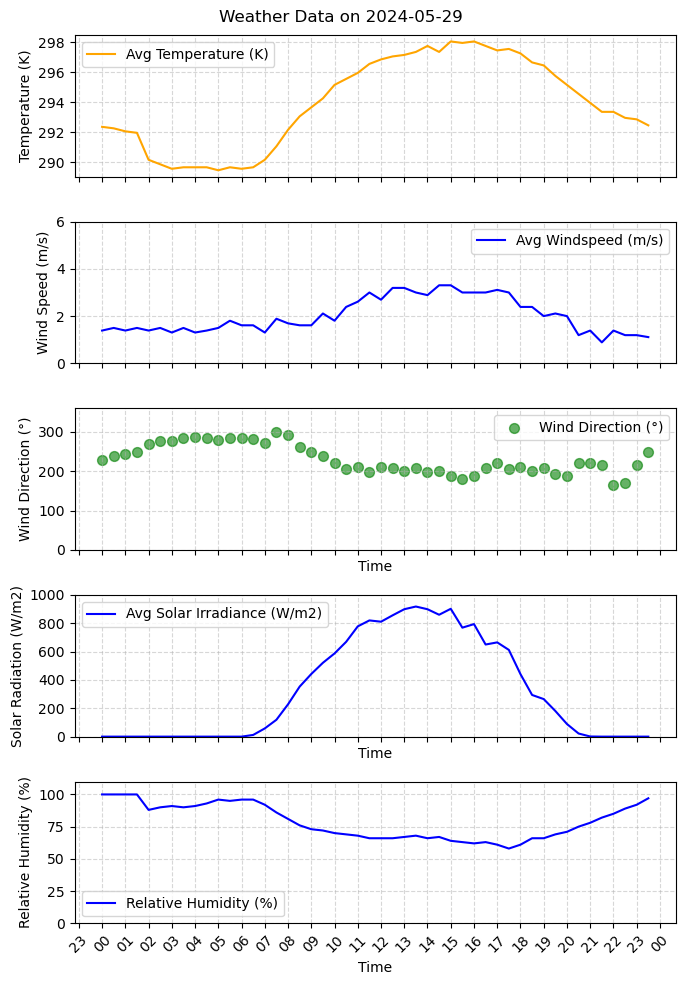

In [11]:
# Filter April 2024 for plotting
# date1, date2 = '2024-04-01', '2024-04-30'
# data = data.loc[date1:date2]
import matplotlib.pyplot as plt

# Filter data for the specific date
date = '2024-05-29'

data_filtered = data.loc[date]
data_filtered['Avg Temperature (K)'] = data_filtered['Avg Temperature (C)'] + 273.15
# Convert wind speed from km/h to m/s
data_filtered['Avg Windspeed (m/s)'] = data_filtered['Avg Windspeed (km/h)'] /3.6

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(7, 10), sharex=True)

# 🔹 Plot 1: Average Temperature
axes[0].plot(data_filtered.index, data_filtered['Avg Temperature (K)'], 
             color='orange', linewidth=1.5, label='Avg Temperature (K)')
# axes[0].set_ylim(22, 34)
axes[0].set_ylabel("Temperature (K)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# 🔹 Plot 2: Wind Speed (m/s)
axes[1].plot(data_filtered.index, data_filtered['Avg Windspeed (m/s)'], 
             color='blue', linewidth=1.5, label='Avg Windspeed (m/s)')
axes[1].set_ylim(0, 6)
axes[1].set_ylabel("Wind Speed (m/s)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# 🔹 Plot 3: Wind Direction (°)
axes[2].scatter(data_filtered.index, data_filtered['Avg Wind Direction'], 
                color='green', marker='o', s=50, alpha=0.6, label='Wind Direction (°)')
axes[2].set_ylim(0, 360)
axes[2].set_ylabel("Wind Direction (°)")
axes[2].set_xlabel("Time")
axes[2].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Major ticks every hour
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format ticks to show only hours
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

# 🔹 Plot 4: Solar Rad (°)
axes[3].plot(data_filtered.index, data_filtered['Avg Solar Irradiance (W/m2)'], 
             color='blue', linewidth=1.5, label='Avg Solar Irradiance (W/m2)')
axes[3].set_ylim(0, 1000)
axes[3].set_ylabel("Solar Radiation (W/m2)")
axes[3].set_xlabel("Time")
axes[3].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Major ticks every hour
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format ticks to show only hours
axes[3].legend()
axes[3].grid(True, linestyle="--", alpha=0.5)

#plot relative humidity
axes[4].plot(data_filtered.index, data_filtered['Relative Humidity'],
             color='blue', linewidth=1.5, label='Relative Humidity (%)')
axes[4].set_ylim(0, 110)
axes[4].set_ylabel("Relative Humidity (%)")
axes[4].set_xlabel("Time")
axes[4].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Major ticks every hour
axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format ticks to show only hours
axes[4].legend()
axes[4].grid(True, linestyle="--", alpha=0.5)


# Formatting
plt.suptitle(f"Weather Data on {date}")
# plt.suptitle(f"Weather Data from March to August 2024")

plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()